# Pathogen Removal in Bank Filtration Systems

## Learning Objectives
- Understand log-removal concepts for pathogen treatment assessment
- Calculate pathogen removal efficiency in groundwater treatment systems
- Learn how heterogeneous systems affect overall performance
- Apply residence time analysis to water treatment design
- Analyze seasonal variations in treatment performance

## Overview

This notebook demonstrates how to calculate pathogen removal efficiency in groundwater treatment systems using log-removal analysis. Understanding pathogen removal is crucial for safe drinking water production from riverbank filtration and managed aquifer recharge systems.

### Real-World Context
Bank filtration is widely used in Europe for drinking water treatment. River water infiltrates through riverbank sediments, where pathogens are naturally filtered out through physical straining and biological decay. The longer water stays underground, the more pathogens are removed.

### Applications
- Drinking water treatment design
- Bank filtration system optimization
- Risk assessment for water supplies
- Treatment performance evaluation
- Treatment performance monitoring

### Key Concepts
- **Log-removal**: Logarithmic scale for pathogen reduction
- **Residence time dependency**: Longer contact time = better removal
- **Heterogeneous systems**: Multiple flow paths with different performance
- **Treatment efficiency**: Quantifying pathogen removal performance

### Background Reading
- [Residence Time](https://gwtransport.github.io/gwtransport/user_guide/concepts.html#concept-residence-time) - Contact time determines removal efficiency
- [Pore Volume Distribution](https://gwtransport.github.io/gwtransport/user_guide/concepts.html#concept-pore-volume-distribution) - Flow path heterogeneity affects overall performance
- [No Reactions Assumption](https://gwtransport.github.io/gwtransport/user_guide/assumptions.html#assumption-no-reactions) - When first-order decay applies

## Theoretical Background

### Log-Removal Fundamentals

Log-removal quantifies pathogen reduction on a logarithmic scale:

$$\text{Log-removal} = \log_{10}\left(\frac{C_{in}}{C_{out}}\right)$$

Where:
- $C_{in}$: Input pathogen concentration
- $C_{out}$: Output pathogen concentration

**Practical Interpretation**:
- 1 log10 = 90% removal (1 in 10 pathogens remain)
- 2 log10 = 99% removal (1 in 100 pathogens remain)  
- 3 log10 = 99.9% removal (1 in 1000 pathogens remain)

### First-Order Decay Model

Log-removal depends on residence time through first-order decay:

$$\text{Log-removal} = \mu \cdot t_{residence}$$

Where:
- $\mu$: Log10 removal rate [log10/day] - depends on pathogen type and aquifer properties
- $t_{residence}$: Residence time [days]

This corresponds to exponential decay of pathogen concentration:

$$\frac{C_{out}}{C_{in}} = 10^{-\mu \cdot t_{residence}}$$

### Connection to Tracer Dating

The first-order decay model is mathematically identical to radioactive decay used in tracer dating. The natural-log decay rate constant $\lambda$ [1/day] is related to $\mu$ by:

$$\lambda = \mu \cdot \ln(10) \quad \Leftrightarrow \quad \mu = \frac{\lambda}{\ln(10)}$$

This means published decay rates from tracer studies can be directly converted to log10 removal rates using `decay_rate_to_log10_removal_rate()`.

### Heterogeneous Systems

For systems with multiple flow paths, the overall log-removal is weighted toward lower values (shorter residence times), providing natural safety margins in design.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from gwtransport import gamma as gamma_utils
from gwtransport.examples import generate_example_data
from gwtransport.logremoval import (
    decay_rate_to_log10_removal_rate,
    gamma_find_flow_for_target_mean,
    gamma_mean,
    parallel_mean,
    residence_time_to_log_removal,
)
from gwtransport.residence_time import residence_time

# Set random seed for reproducibility
np.random.seed(42)
plt.style.use("seaborn-v0_8-whitegrid")

print("Libraries imported successfully")

Libraries imported successfully


## 1. Understanding Basic Log-Removal

We start with a simple example to illustrate the fundamental relationship between residence time and pathogen removal.

In [2]:
print("=== Basic Log-Removal Calculation ===")
print("Simulating a small bank filtration system...\n")

# Define aquifer characteristics (small riverbank aquifer)
mean_pore_volume = 1000.0  # m³ (total water-filled space)
std_pore_volume = 300.0  # m³ (variability in pore volume)
flow_rate = 50.0  # m³/day (water extraction rate)
log10_removal_rate = 0.2  # log10/day (typical for bacteria, ~0.1-0.3 log10/day)

# Convert aquifer properties to gamma distribution parameters
alpha, beta = gamma_utils.mean_std_to_alpha_beta(mean=mean_pore_volume, std=std_pore_volume)

# Calculate residence time statistics
rt_alpha = alpha
rt_beta = beta / flow_rate

# Calculate pathogen log-removal
mean_log_removal = gamma_mean(rt_alpha=rt_alpha, rt_beta=rt_beta, log10_removal_rate=log10_removal_rate)
removal_efficiency = (1 - 10 ** (-mean_log_removal)) * 100

# Display results
mean_residence_time = mean_pore_volume / flow_rate

print("Aquifer Setup:")
print(f"  - Pore volume: {mean_pore_volume:.0f} +/- {std_pore_volume:.0f} m3")
print(f"  - Flow rate: {flow_rate} m3/day")
print(f"  - Mean residence time: {mean_residence_time:.1f} days")
print(f"  - Log10 removal rate: {log10_removal_rate} log10/day")

print("\nPathogen Removal Results:")
print(f"  - Log-removal: {mean_log_removal:.2f} log10")
print(f"  - Removal efficiency: {removal_efficiency:.1f}%")
print(f"  - Remaining pathogens: {100 - removal_efficiency:.1f}%")

=== Basic Log-Removal Calculation ===
Simulating a small bank filtration system...

Aquifer Setup:
  - Pore volume: 1000 +/- 300 m3
  - Flow rate: 50.0 m3/day
  - Mean residence time: 20.0 days
  - Log10 removal rate: 0.2 log10/day

Pathogen Removal Results:
  - Log-removal: 4.00 log10
  - Removal efficiency: 100.0%
  - Remaining pathogens: 0.0%


In [3]:
print("=== Connection to Tracer Dating ===")
print("Converting a published natural-log decay rate to log10 removal rate\n")

# Published decay rate from a tracer study (natural-log based)
# Example: λ = 0.46 per day (from a radioactive tracer experiment)
published_decay_rate = 0.46  # 1/day (natural-log decay rate)

# Convert to log10 removal rate
converted_rate = decay_rate_to_log10_removal_rate(published_decay_rate)

print(f"Published decay rate (lambda): {published_decay_rate} 1/day")
print(f"Converted log10 removal rate (mu): {converted_rate:.4f} log10/day")
print(f"\nVerification: mu * ln(10) = {converted_rate * np.log(10):.4f} (should equal lambda)")
print(f"\nThis means for a residence time of {mean_residence_time:.0f} days:")
print(
    f"  Log-removal = {converted_rate:.4f} * {mean_residence_time:.0f} = {converted_rate * mean_residence_time:.2f} log10"
)

=== Connection to Tracer Dating ===
Converting a published natural-log decay rate to log10 removal rate

Published decay rate (lambda): 0.46 1/day
Converted log10 removal rate (mu): 0.1998 log10/day

Verification: mu * ln(10) = 0.4600 (should equal lambda)

This means for a residence time of 20 days:
  Log-removal = 0.1998 * 20 = 4.00 log10


## 2. Heterogeneous System Performance

Bank filtration systems have multiple flow paths with different residence times. The overall log-removal is weighted toward lower values (shorter residence times).

In [4]:
print("=== Heterogeneous System Analysis ===")
print("Multiple flow paths with different residence times\n")

# Three flow paths with different log-removal efficiencies
unit_removals = np.array([0.5, 1.0, 1.5])  # log10 values for each path

# Correct method: parallel_mean() accounts for flow-weighted averaging
combined_removal = parallel_mean(log_removals=unit_removals)

print("Flow Path Performance:")
for i, removal in enumerate(unit_removals):
    efficiency = (1 - 10 ** (-removal)) * 100
    print(f"  Path {i + 1}: {removal:.1f} log10 -> {efficiency:.1f}% removal")

print("\nOverall System Performance:")
combined_efficiency = (1 - 10 ** (-combined_removal)) * 100
print(f"  Combined log-removal: {combined_removal:.2f} log10 -> {combined_efficiency:.1f}% removal")

print("\nNote: Overall performance is weighted toward the worst-performing paths")
print("(shortest residence times), ensuring conservative design.")

=== Heterogeneous System Analysis ===
Multiple flow paths with different residence times

Flow Path Performance:
  Path 1: 0.5 log10 -> 68.4% removal
  Path 2: 1.0 log10 -> 90.0% removal
  Path 3: 1.5 log10 -> 96.8% removal

Overall System Performance:
  Combined log-removal: 0.83 log10 -> 85.1% removal

Note: Overall performance is weighted toward the worst-performing paths
(shortest residence times), ensuring conservative design.


## 3. Design Application - Achieving Target Removal Efficiency

Water treatment facilities aim to achieve specific pathogen removal targets. We demonstrate how to design systems that achieve desired removal efficiency.

In [5]:
print("=== Design Application ===")
print("Design challenge: Achieve target pathogen removal for safe drinking water\n")

# Target removal level for pathogen safety
target_removal = 6.0
target_efficiency = (1 - 10 ** (-target_removal)) * 100

print(f"Target: {target_removal} log10 removal ({target_efficiency:.0f}% efficiency)")

# Find the maximum flow rate that still achieves our target
required_flow = gamma_find_flow_for_target_mean(
    target_mean=target_removal,
    apv_alpha=alpha,
    apv_beta=beta,
    log10_removal_rate=log10_removal_rate,
)

required_residence_time = mean_pore_volume / required_flow

print("\nDesign Solution:")
print(f"  - Maximum flow rate: {required_flow:.1f} m3/day")
print(f"  - Required residence time: {required_residence_time:.1f} days")
print(f"  - Daily water production: {required_flow:.1f} m3 = {required_flow * 1000:.0f} liters")

# Compare with original flow rate
flow_reduction = (1 - required_flow / flow_rate) * 100
print("\nComparison with original design:")
print(f"  - Flow reduction needed: {flow_reduction:.1f}%")
print(f"  - Production capacity: {required_flow / flow_rate * 100:.1f}% of original")

print("\nEngineering Insight: Higher flow rates mean shorter residence times,")
print("which reduces pathogen removal. There's always a trade-off between")
print("water production capacity and treatment effectiveness.")

=== Design Application ===
Design challenge: Achieve target pathogen removal for safe drinking water

Target: 6.0 log10 removal (100% efficiency)

Design Solution:
  - Maximum flow rate: 33.3 m3/day
  - Required residence time: 30.0 days
  - Daily water production: 33.3 m3 = 33333 liters

Comparison with original design:
  - Flow reduction needed: 33.3%
  - Production capacity: 66.7% of original

Engineering Insight: Higher flow rates mean shorter residence times,
which reduces pathogen removal. There's always a trade-off between
water production capacity and treatment effectiveness.


## 4. Real-World Scenario - Seasonal Variations

In reality, river flows change seasonally, affecting bank filtration performance. We simulate a multi-year system to see how log-removal varies with changing conditions.

In [6]:
print("=== Seasonal Flow Data Generation ===")

# Generate realistic flow data with seasonal patterns
df, tedges = generate_example_data(
    date_start="2020-01-01",
    date_end="2025-05-31",
    flow_mean=120.0,  # Base flow rate [m³/day]
    flow_amplitude=40.0,  # Seasonal flow variation [m³/day]
    flow_noise=5.0,  # Random daily fluctuations [m³/day]
    temp_infiltration_method="soil_temperature",  # Use real soil temperature data
    aquifer_pore_volume_gamma_mean=8000.0,  # True mean pore volume [m³]
    aquifer_pore_volume_gamma_std=400.0,  # True standard deviation [m³]
    retardation_factor=2.0,  # Thermal retardation factor [-]
)

# Set up aquifer characteristics for this larger system
bins = gamma_utils.bins(
    mean=df.attrs["aquifer_pore_volume_gamma_mean"], std=df.attrs["aquifer_pore_volume_gamma_std"], n_bins=1000
)  # High resolution

print(f"Dataset: {len(df)} days from {df.index[0].date()} to {df.index[-1].date()}")
print(f"Flow range: {df['flow'].min():.1f} - {df['flow'].max():.1f} m³/day")
print(
    f"Aquifer: {df.attrs['aquifer_pore_volume_gamma_mean']:.0f} ± {df.attrs['aquifer_pore_volume_gamma_std']:.0f} m³ pore volume"
)

=== Seasonal Flow Data Generation ===
Dataset: 1978 days from 2020-01-01 to 2025-05-31
Flow range: 8.1 - 170.0 m³/day
Aquifer: 8000 ± 400 m³ pore volume


In [7]:
print("\nComputing pathogen removal over time...")

# Calculate residence time distribution for water flow
rt_infiltration_to_extraction_water = residence_time(
    flow=df.flow,
    flow_tedges=tedges,
    aquifer_pore_volumes=bins["expected_values"],
    retardation_factor=1.0,  # Water (conservative tracer)
    direction="infiltration_to_extraction",
)

# Compute log-removal for each flow path and time point
log_removal_array = residence_time_to_log_removal(
    residence_times=rt_infiltration_to_extraction_water,
    log10_removal_rate=log10_removal_rate,
)

# Average across all flow paths (using correct parallel averaging)
df["log_removal"] = parallel_mean(log_removals=log_removal_array, axis=0)
df["removal_efficiency"] = (1 - 10 ** (-df["log_removal"])) * 100

print("Time series calculation completed")
print(f"Log-removal range: {df['log_removal'].min():.2f} - {df['log_removal'].max():.2f} log10")
print(f"Efficiency range: {df['removal_efficiency'].min():.1f}% - {df['removal_efficiency'].max():.1f}%")


Computing pathogen removal over time...
Time series calculation completed
Log-removal range: 9.71 - 21.67 log10
Efficiency range: 100.0% - 100.0%


## 5. Performance Visualization

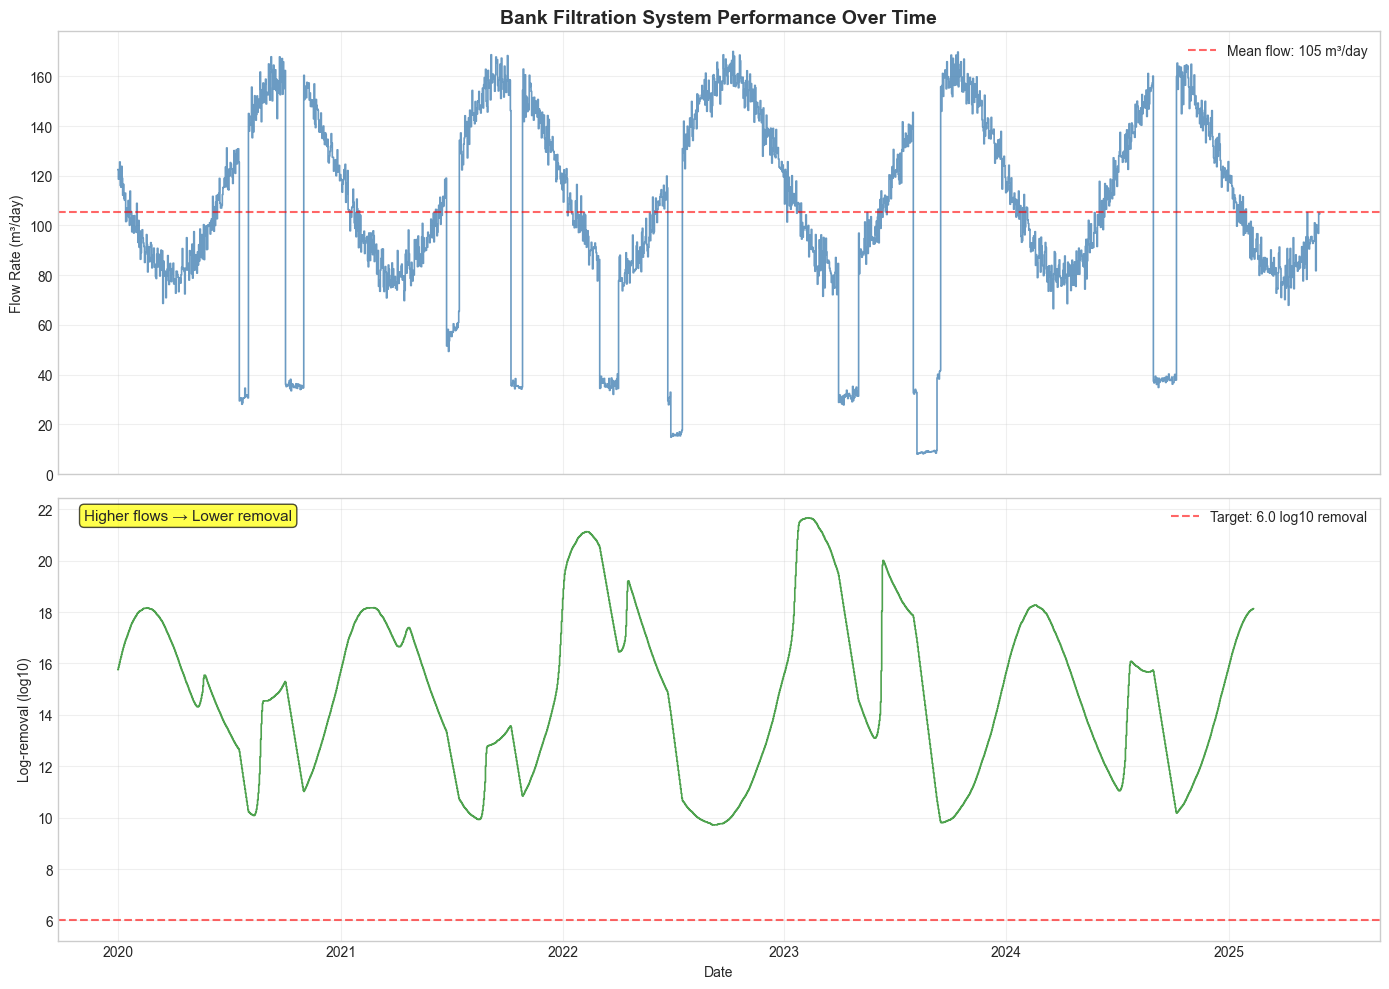

📈 Time series plot saved to: 03_log_removal_time_series.png


In [8]:
# Create informative time series plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot 1: Flow rate over time - convert to step format
xstep_flow, ystep_flow = np.repeat(tedges, 2)[1:-1], np.repeat(df.flow, 2)
ax1.plot(xstep_flow, ystep_flow, color="steelblue", linewidth=1.2, alpha=0.8)
ax1.set_ylabel("Flow Rate (m³/day)")
ax1.set_title("Bank Filtration System Performance Over Time", fontsize=14, fontweight="bold")
ax1.grid(True, alpha=0.3)
ax1.axhline(
    y=df.flow.mean(),
    color="red",
    linestyle="--",
    alpha=0.6,
    label=f"Mean flow: {df.flow.mean():.0f} m³/day",
)
ax1.legend()

# Plot 2: Log-removal over time - convert to step format
xstep_removal, ystep_removal = np.repeat(tedges, 2)[1:-1], np.repeat(df.log_removal, 2)
ax2.plot(xstep_removal, ystep_removal, color="forestgreen", linewidth=1.2, alpha=0.8)
ax2.set_ylabel("Log-removal (log10)")
ax2.set_xlabel("Date")
ax2.grid(True, alpha=0.3)

# Add target removal line
ax2.axhline(y=target_removal, color="red", linestyle="--", alpha=0.6, label=f"Target: {target_removal} log10 removal")
ax2.legend()

# Add seasonal annotations
ax2.text(
    0.02,
    0.95,
    "Higher flows → Lower removal",
    transform=ax2.transAxes,
    fontsize=11,
    bbox={"boxstyle": "round,pad=0.3", "facecolor": "yellow", "alpha": 0.7},
)

plt.tight_layout()

# Save the time series plot
out_path = Path("03_log_removal_time_series.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"📈 Time series plot saved to: {out_path}")

## 6. Performance Summary and Analysis

In [9]:
# Calculate and display summary statistics
min_removal = df["log_removal"].min()
max_removal = df["log_removal"].max()
mean_removal = df["log_removal"].mean()
min_efficiency = df["removal_efficiency"].min()
max_efficiency = df["removal_efficiency"].max()
std_removal = df["log_removal"].std()

# Target removal analysis
target_removal_threshold = 6.0  # log10 removal target

target_achieved_days = (df["log_removal"] >= target_removal_threshold).sum()
target_achieved_percent = target_achieved_days / len(df) * 100

# Flow-removal correlation
flow_removal_corr = np.corrcoef(df["flow"], df["log_removal"])[0, 1]

print("📊 Performance Summary (6-year analysis):")
print("=" * 50)
print("Log-removal statistics:")
print(f"  • Range: {min_removal:.2f} - {max_removal:.2f} log10")
print(f"  • Mean: {mean_removal:.2f} ± {std_removal:.2f} log10")
print(f"  • Efficiency range: {min_efficiency:.1f}% - {max_efficiency:.1f}%")

print(f"\nTarget Achievement (≥{target_removal_threshold} log10):")
print(f"  • Days achieving target: {target_achieved_days} / {len(df)} ({target_achieved_percent:.1f}%)")

print("\n🔍 Key Observation: Higher flows → shorter residence times → less pathogen removal")
print("   This seasonal variation is critical for water treatment plant design!")

📊 Performance Summary (6-year analysis):
Log-removal statistics:
  • Range: 9.71 - 21.67 log10
  • Mean: 14.83 ± 3.14 log10
  • Efficiency range: 100.0% - 100.0%

Target Achievement (≥6.0 log10):
  • Days achieving target: 1869 / 1978 (94.5%)

🔍 Key Observation: Higher flows → shorter residence times → less pathogen removal
   This seasonal variation is critical for water treatment plant design!


## Results & Discussion

### Seasonal Performance Variations
The time series analysis reveals significant seasonal variations in pathogen removal efficiency:
- **High flow periods**: Reduced residence times lead to lower log-removal
- **Low flow periods**: Extended residence times improve pathogen removal
- **Design implications**: Systems must be designed for worst-case (high flow) conditions

### Heterogeneous System Behavior
The analysis demonstrates key characteristics of heterogeneous systems:
- **Weighted averaging**: Overall performance is weighted toward worst-performing flow paths
- **Conservative design**: Shortest residence times control overall system performance
- **Safety margins**: This natural conservatism provides built-in safety factors

### Engineering Design Insights

**Flow Rate Optimization**:
- Trade-off between water production and treatment efficiency
- Maximum safe flow rates depend on target removal requirements
- Consider seasonal flow variations in design

**Risk Management**:
- Monitor performance during high-flow periods
- Consider backup treatment during low-performance periods
- Design for high achievement of target removal levels

**System Optimization**:
- Identify and mitigate fast flow paths
- Consider engineered barriers to increase residence times
- Implement real-time monitoring for adaptive management

## Key Takeaways

✅ **Log-Removal Fundamentals**: Logarithmic scale quantifies pathogen reduction efficiency

✅ **Residence Time Dependency**: Longer underground residence = better pathogen removal

✅ **Flow Rate Trade-off**: Higher pumping rates reduce treatment efficiency

✅ **Heterogeneous Systems**: Overall performance weighted toward worst-performing flow paths

✅ **Seasonal Variations**: Flow changes cause significant performance variations

✅ **Safety Margins**: Design for worst-case conditions and high target achievement rates

## Engineering Design Summary

### Essential Principles for Bank Filtration Design

**1. Fundamental Relationship (First-Order Decay)**:
```
Log-removal = mu x residence_time
```
where mu is the log10 removal rate [log10/day]. Longer underground residence = better pathogen removal.

**2. Flow Rate Trade-off**:
Higher pumping rates -> shorter residence times -> less removal  
Engineers must balance water demand with treatment efficiency.

**3. Heterogeneous System Performance**:
Overall log-removal is weighted toward lower values (shorter residence times).  
This provides natural safety margins in design.

**4. Design Tools**:
Use `gamma_find_flow_for_target_mean()` to find maximum safe flow rates.  
Essential for achieving target pathogen removal.

**5. Tracer Dating Connection**:
Convert published natural-log decay rates to log10 removal rates with  
`decay_rate_to_log10_removal_rate()` for direct use in removal calculations.

**6. Seasonal Considerations**:
Design for worst-case (high flow) conditions.  
Ensure year-round achievement of target removal levels.